# Problem Statement
With increasing number of mass shooting incidents at schools, malls and other public places across US of A, there is a need of effective monitoring systems that can identify potential dangers and alert beforehand. Law enforcement agencies that guard public places currently rely on technology like walk-through or handheld magnetometers, which detect changes in local magnetic fields.

The requirement is to create an AI powered gun detection system that can identify threats by connecting with the existing video surveillance cameras to reliably and rapidly recognize firearms and immediately trigger multi-channel alerts and automate pre-defined safety protocols.

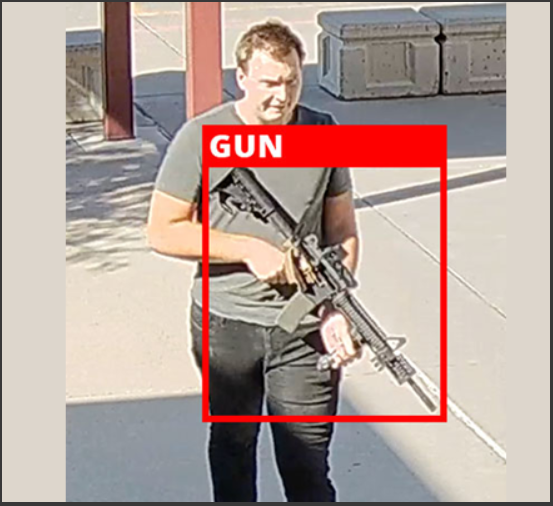

In [1]:
import os
import random
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# notebook configuration
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")
# plt.rcParams['figure.figsize'] = (20, 10)

# Introduction To Object Detection
In Image classification, CNNs were developed to detect objects present anywhere in an image and assign them with a probability scores and labels. The class labels and probability scores are generally associated with the full image and care about the presence or absence of the object of interest in the image. 

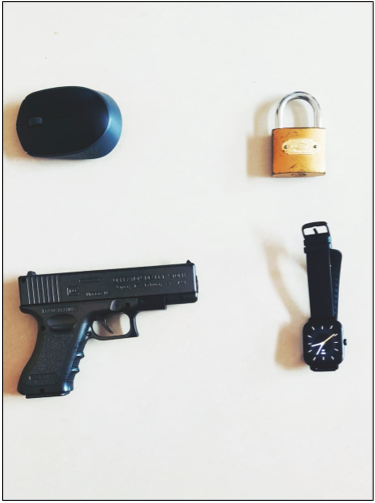

But what if there is need to find the location of the object of interest in the image or how many objects are present in the image?

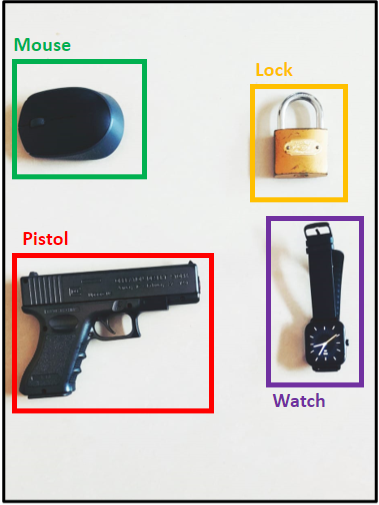

Object detection addresses these limitations by not only identifying the presence of objects but also pinpointing their exact locations within an image. This is typically achieved by drawing bounding boxes around the detected objects.

### Key differences from Image Classification
- Granularity: Image classification provides a label for the entire image, while object detection focuses on individual objects within the image.
- Output:
    - Image classification: Class label and probability score.
    - Object detection: Class label, probability score and bounding box coordinates.
- Spatial information: Object detection explicitly considers the spatial relationships between objects in the image.

### Applications of Object Detection
- Self-driving cars: Detecting pedestrians, vehicles and traffic signs.
- Surveillance systems: Identifying and tracking individuals or objects of interest.
- Medical image analysis: Detecting tumors or anomalies in medical images.
- Retail: Analyzing customer behavior and inventory management.
- Robotics: Enabling robots to interact with the environment.

In summary, object detection is a crucial task in Computer Vision that provides more detailed information about the content of an image compared to image classification. By combining object localization and classification, it enables a wide range of applications that require understanding the spatial arrangement of object in a scene.

# Loading And Exploring The Dataset

In [3]:
datapath = "pistol_data/"
!ls {datapath}

pistol_annotations pistol_images


In [4]:
annot_files = sorted(os.listdir(f"{datapath}pistol_annotations"))
img_files = sorted(os.listdir(f"{datapath}pistol_images"))

print(f'Total files: {len(annot_files)}')
print(f'Top 5: {annot_files[:5]}')
print(f'Top 5: {img_files[:5]}')

Total files: 3703
Top 5: ['1.txt', '10.txt', '100.txt', '1000.txt', '1001.txt']
Top 5: ['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']


In [5]:
# content in each of the annotation files
for annot_file in annot_files[0: 5]:
    with open(f"{datapath}pistol_annotations/{annot_file}", "r") as file:
        print(file.readlines())

['1 0.4253846153846154 0.2447973713033954 0.22153846153846152 0.2814895947426068']
['1 0.4983922829581993 0.4907407407407407 0.3665594855305466 0.4506172839506173']
['1 0.6466602129719264 0.28387096774193543 0.08131655372700872 0.05935483870967742']
['1 0.5747967479674796 0.39390243902439026 0.27804878048780485 0.3341463414634146']
['1 0.5061538461538462 0.4229559748427673 0.3353846153846154 0.3050314465408805']


Each `.txt` file inside pistol_annotations contains 4 point coordinated which represent the location of the Gun in the corresponding image as (`x_center`, `y_center`, `width`, `height`).

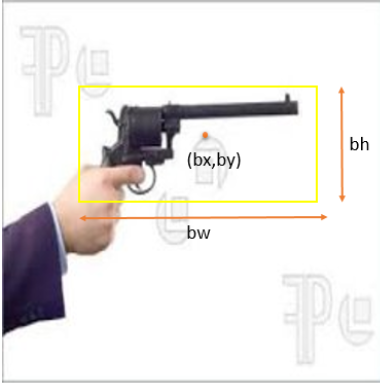

[1.0, 0.4253846153846154, 0.2447973713033954, 0.22153846153846152, 0.2814895947426068]
Image Resolution (416, 416, 3)
[1.0, 0.5188888888888888, 0.6283333333333333, 0.22, 0.27]
Image Resolution (416, 416, 3)
[1.0, 0.5672727272727273, 0.27322404371584696, 0.4290909090909091, 0.5027322404371584]
Image Resolution (416, 416, 3)
[1.0, 0.6140684410646388, 0.23177083333333331, 0.49809885931558934, 0.2864583333333333]
Image Resolution (416, 416, 3)
[1.0, 0.6994535519125683, 0.37999999999999995, 0.07650273224043716, 0.23636363636363636]
Image Resolution (416, 416, 3)


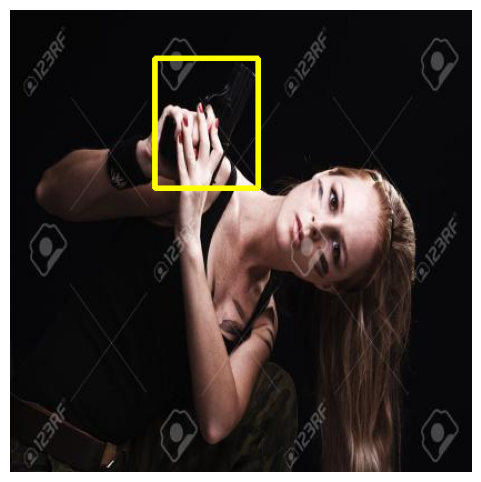

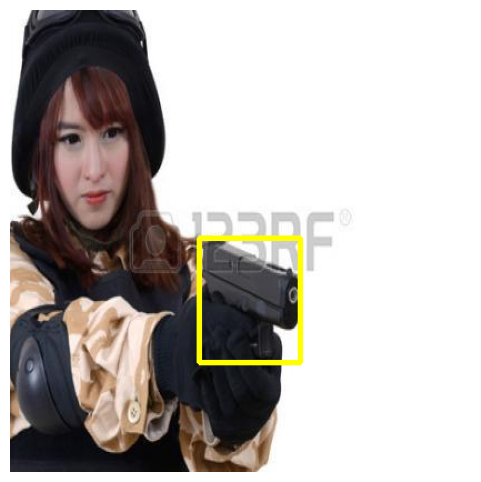

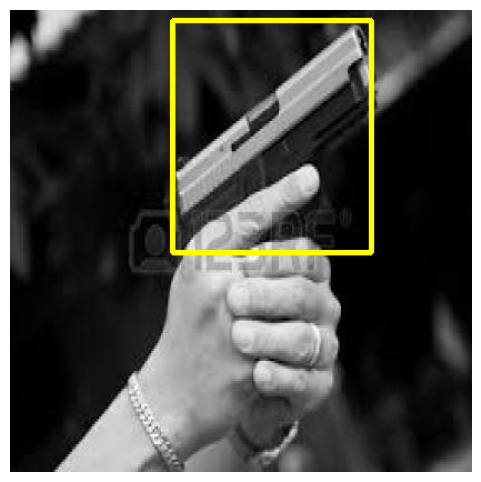

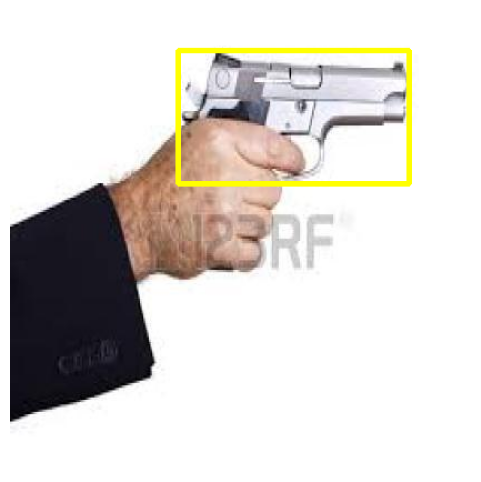

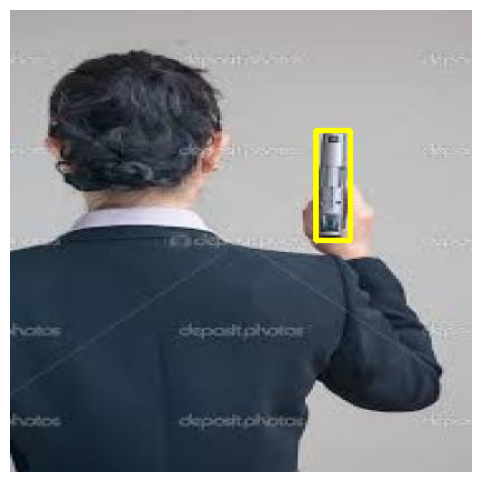

In [6]:
import cv2

img_h = 416
img_w = 416

def cv_coords(box):
    """
    This function will convert B.B cordinates from (X_center,Y_center,width,height) format
    to (x_start,y_start,x_end,y_end) required for cv2 to annotate rectangle on objects
    """
    x, y, w, h= box[1], box[2], box[3], box[4]
    x1, y1 = int((x - w/2) * img_w), int((y - h/2) * img_h)
    x2, y2 = int((x + w/2) * img_w), int((y + h/2) * img_h)
    return x1, y1, x2, y2

def plot_img_and_box(img, bbox):
    plt.figure(figsize = (6, 6))
    print("Image Resolution",img.shape)
    bbox = cv_coords(bbox)
    start_point = (bbox[0], bbox[1])
    end_point = (bbox[2], bbox[3])
    # convert to writable format (or make a copy)
    img = img.copy() 
    img = cv2.rectangle(img, start_point, end_point, (255, 255, 0), 3)
    plt.axis("off")
    plt.imshow(img)

for i in range(5):
    img_path = f"{datapath}pistol_images/{i+1}.jpg"
    label_path = f"{datapath}pistol_annotations/{i+1}.txt"

    img = plt.imread(img_path)

    with open(label_path, "r") as file:
        bbox = (file.readlines())
        bbox = [float(element) for element in bbox[0].split(" ")]
        print(bbox)

    plot_img_and_box(img, bbox)

# Classification + Localization
The CNN architecture can be modified for classification and localization, the final layers will have to be adapted to output both the class probability and the bounding box coordinates. The following is a common approach,
1. Feature extraction backbone: Retain the existing convolutional layers of the chosen CNN architecture (e.g., VGG, ResNet, EfficientNet) to extract features from the input image.
2. Dual-head output layer:
    - Classification head:
        - Add a fully connected (FC) layer with the number of units equal to the number of classes.
        - Apply a softmax activation function to obtain class probabilities.
    - Localization head:
        - Add another FC layer with four output units.
        - Each unit represents:
            - x-coordinate of the bounding box center.
            - y-coordinate of the bounding box center.
            - width of the bounding box.
            - height of the bounding box.
3. Loss function:
    - Classification loss: Use cateforical cross-entropy loss to measure the discrepancy between predicted and true class probabilities.
    - Localization loss: Use L1 or L2 loss (Mean Absolute Error or Mean Squared Error) to measure the difference between predicted and ground-truth bounding box coordinates.
    - Combined loss: Combine the classification and localization losses with appropriate weights.

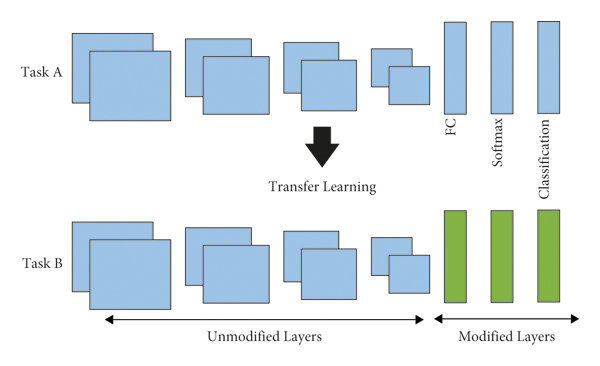

### Key points
- The feature extraction backbone provides a rich representation of the image.
- The dual-head output layer allows the network to simultaneously predict both the class and the bounding box.
- The choice of loss function is crucial for training the model effectively.

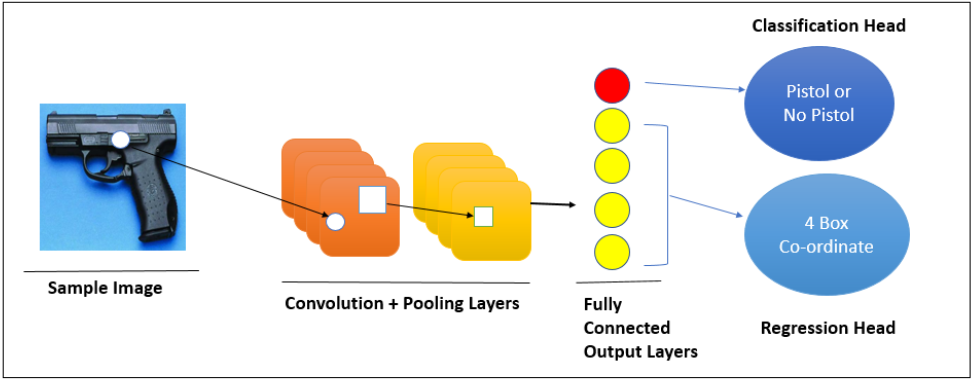

In [7]:
# loading the dataset into arrays
from tqdm.auto import tqdm

def return_bbox(label_path):
    """
    read and return bbox from text file
    """
    with open(label_path, "r") as file:
        bbox = (file.readlines())
        bbox = [float(element) for element in bbox[0].split(" ")]
        return bbox[0], bbox[1: ]

def return_image_label(filename):
    """
    read and return image as well as corresponding label and bbox from image file
    """
    try:
        img_path = f"{datapath}pistol_images/{filename}.jpg"
        image = plt.imread(img_path)
        label_path = f"{datapath}pistol_annotations/{filename}.txt"
        class_label, bbox_label = return_bbox(label_path)
        return True, image, class_label, bbox_label
    except Exception as e:
        print("Exception: ", filename, str(e))
        return False, None, None, None


### Looping over all the files present in directory to extract image, labels and bbox
images, class_labels, bbox_labels = [], [], []
for filename in tqdm(annot_files):
    filename = filename[: -4]
    status, image, class_label, bbox_label= return_image_label(filename)
    if status == True and image.shape == (416,416,3):
        images.append(image)
        class_labels.append(class_label)
        bbox_labels.append(bbox_label)


images, class_labels, bbox_labels = np.array(images),np.array(class_labels),np.array(bbox_labels)
images.shape, class_labels.shape, bbox_labels.shape

100%|██████████| 3703/3703 [00:03<00:00, 981.41it/s] 


((3703, 416, 416, 3), (3703,), (3703, 4))

In [8]:
class_label

1.0

In [9]:
bbox_labels

array([[0.42538462, 0.24479737, 0.22153846, 0.28148959],
       [0.49839228, 0.49074074, 0.36655949, 0.45061728],
       [0.64666021, 0.28387097, 0.08131655, 0.05935484],
       ...,
       [0.66423077, 0.51078799, 0.45153846, 0.815197  ],
       [0.49666667, 0.49450549, 0.92666667, 0.79120879],
       [0.48653846, 0.45345188, 0.97153846, 0.90481172]])

In [10]:
# frequency distribution of gun and no-gun class
np.unique(class_labels, return_counts = True)

(array([0., 1.]), array([ 999, 2704]))

There are 999 images with no guns and 2704 images with guns present in the frame.

In [11]:
# splitting the dataset into train and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_class, y_test_class, y_train_box, y_test_box = train_test_split(images, class_labels, bbox_labels, test_size = 0.30, random_state = 42)
x_train.shape, x_test.shape, y_train_class.shape, y_test_class.shape, y_train_box.shape, y_test_box.shape

((2592, 416, 416, 3),
 (1111, 416, 416, 3),
 (2592,),
 (1111,),
 (2592, 4),
 (1111, 4))

In [12]:
y_train_class

array([1., 0., 1., ..., 1., 1., 1.])

In [13]:
y_train_box

array([[0.41620112, 0.56560284, 0.24022346, 0.10992908],
       [0.        , 0.        , 0.        , 0.        ],
       [0.48333333, 0.50518519, 0.75555556, 0.89481481],
       ...,
       [0.496875  , 0.5       , 0.98125   , 0.95      ],
       [0.5       , 0.47757848, 0.996875  , 0.95067265],
       [0.517     , 0.51201201, 0.694     , 0.96996997]])

In [14]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
# creating the architecture to generate bbox coordinates along with class probability
ResNet101 = tf.keras.applications.ResNet101(weights = "imagenet", include_top = False, input_tensor = tf.keras.layers.Input(shape = (416, 416, 3)))

# setting trainable parameter to False
ResNet101.trainable = False

# adding some trainable dense layers
res_output = ResNet101.output
flat = tf.keras.layers.Flatten()(res_output)

# classification head
x1 = tf.keras.layers.Dense(128, activation = "relu")(flat)
x1 = tf.keras.layers.Dense(64, activation = "relu")(x1)
x1 = tf.keras.layers.Dense(32, activation = "relu")(x1)

# classification output: single class
class_out = tf.keras.layers.Dense(1, activation = "sigmoid", name = "class_output")(x1)

# regression head
x1 = tf.keras.layers.Dense(128, activation = "relu")(flat)
x1 = tf.keras.layers.Dense(64, activation = "relu")(x1)
x1 = tf.keras.layers.Dense(32, activation = "relu")(x1)

# regression output: 4 bbox coordinates
reg_out = tf.keras.layers.Dense(4, activation = "sigmoid", name = "box_output")(x1)

ResNet101_final = tf.keras.models.Model(ResNet101.input, [reg_out, class_out])

2025-02-10 12:41:59.439582: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-10 12:41:59.440483: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-10 12:41:59.440491: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1739171519.441927 7114115 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739171519.443362 7114115 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
ResNet101_final.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 422, 422,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 208, 208,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 208, 208,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 208, 208,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 210, 210,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 104, 104,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 104, 104,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 104, 104,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 104, 104,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 104, 104,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 104, 104,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 104, 104,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 104, 104,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 104, 104,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_3_c

 Total params: 131,283,941 (500.81 MB)

 Trainable params: 88,625,765 (338.08 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

# Model Configuration And Loss Function Mappings

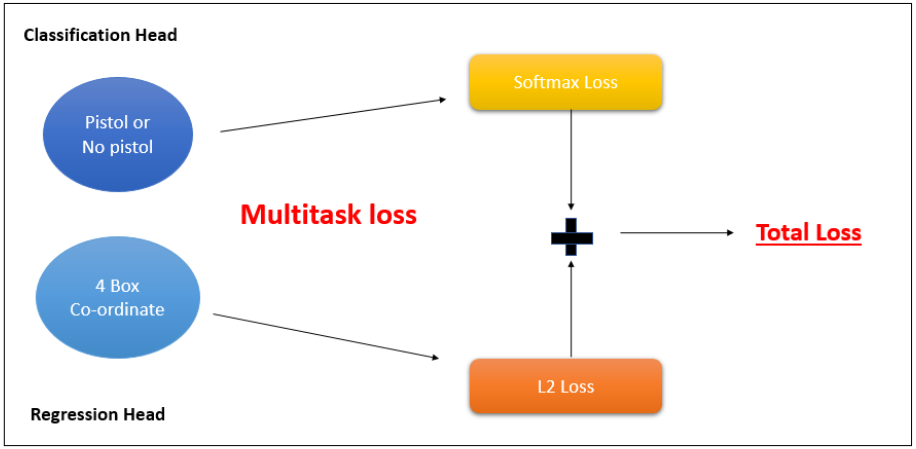

In [17]:
# loss for classification + regression
losses = {
    "class_output": "binary_crossentropy",
    "box_output": "mean_squared_error"
}

# loss weight: optional
loss_weights = {
    "box_output": 4.0,
    "class_output": 1.0
}

# metrics for both head to track
metrics = {
    "box_output": "mse",
    "class_output": "accuracy"
}

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [18]:
# compiling the model
ResNet101_final.compile(optimizer = optimizer, loss = losses, loss_weights = loss_weights, metrics = metrics)

In [19]:
# confirming if GPU support is enabled
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)

GPU details:  {'device_name': 'METAL'}


In [21]:
# # setup for tensorboard visualization
# log_dir = "pistol_log"
# !rm -rf log_dir
# tensorboard_callback = tf.keras.callbacks.Tensorboards(log_dir = log_dir)

# training the model
history = ResNet101_final.fit(
    x = x_train, 
    y = {"class_output": y_train_class, "box_output": y_train_box},
    validation_data = (x_test, {"class_output": y_test_class, "box_output": y_test_box}),
    batch_size = 32,
    epochs = 10
    # callbacks = (tensorboard_callback)
)

Epoch 1/10


2025-02-10 12:42:14.989562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


81/81 ━━━━━━━━━━━━━━━━━━━━ 471s 6s/step - box_output_loss: 0.1639 - box_output_mse: 0.1639 - class_output_accuracy: 0.8612 - class_output_loss: 4.6146 - loss: 5.2703 - val_box_output_loss: 0.1292 - val_box_output_mse: 0.1290 - val_class_output_accuracy: 0.9847 - val_class_output_loss: 0.3514 - val_loss: 0.8704
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 477s 6s/step - box_output_loss: 0.1275 - box_output_mse: 0.1275 - class_output_accuracy: 0.9841 - class_output_loss: 0.4095 - loss: 0.9193 - val_box_output_loss: 0.1230 - val_box_output_mse: 0.1228 - val_class_output_accuracy: 0.9874 - val_class_output_loss: 0.2229 - val_loss: 0.7159
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step - box_output_loss: 0.1256 - box_output_mse: 0.1256 - class_output_accuracy: 0.9963 - class_output_loss: 0.1263 - loss: 0.6287 - val_box_output_loss: 0.1330 - val_box_output_mse: 0.1328 - val_class_output_accuracy: 0.9955 - val_class_output_loss: 0.0719 - val_loss: 0.6036
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 519s

Both class loss and bbox loss are decreasing continuously as expected.

In [22]:
# visualizing the training on tensorboard
# pip install tensorboard
# %load_ext tensorboard
# %tensorboard --logdir={log_dir}

The localization model is ready and can be used for inference and evaluation.

# Prediction And Evaluation

### Prediction on images in the test set

In [23]:
def predict(input_img_arr, model, mode = "single"):
    if mode is "single":
        input_img_arr = np.expand_dims(input_img_arr, axis = 0)
        pred_box, class_prob = model.predict(input_img_arr)
        return pred_box[0], class_prob[0]
    else:
        pred_box, class_prob = model.predict(input_img_arr)
        return pred_box, class_prob

predict(x_test[0], ResNet101_final)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


(array([0.0000000e+00, 1.2704124e-23, 0.0000000e+00, 0.0000000e+00],
       dtype=float32),
 array([1.], dtype=float32))

In [24]:
predict(x_test[0: 4], ResNet101_final, "batch")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


(array([[0.0000000e+00, 1.2703977e-23, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 4.8380521e-36],
        [0.0000000e+00, 2.9506828e-27, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
       dtype=float32),
 array([[1.],
        [1.],
        [0.],
        [0.]], dtype=float32))

### Evaluation (MSE and BCE on test)

In [25]:
eval_res = ResNet101_final.evaluate(x_test, {"class_output": y_test_class, "box_output": y_test_box})

35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - box_output_loss: 0.1299 - box_output_mse: 0.1299 - class_output_accuracy: 0.9927 - class_output_loss: 0.2804 - loss: 0.8002


In [26]:
print(f"Total Loss: {eval_res[0]}\nBBox MSE Loss{eval_res[1]}\nClass BCE Loss: {eval_res[2]}\nBBox MSE: {eval_res[3]}\nAccuracy Score: {eval_res[4]}\n")

Total Loss: 0.6304948329925537
BBox MSE Loss0.13368375599384308
Class BCE Loss: 0.09446612745523453
BBox MSE: 0.13381581008434296
Accuracy Score: 0.9963996410369873



Plotting the predicted bounding boxes (bbox) against the ground truth boxes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Ground Truth:  [0.50625    0.45416667 0.9125     0.89166667]
Prediction:  [0. 0. 1. 1.]
ImgResolution (416, 416, 3)


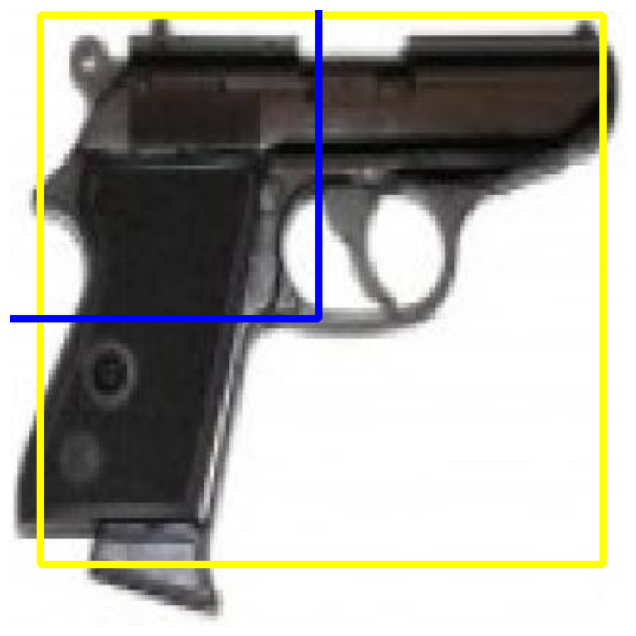

In [27]:
def cv_coords(box):
    """
    This function will convert B.B cordinates from (X_center,Y_center,width,height)  format
    to (x_start,y_start,x_end,y_end) required for cv2 to create rectangle
    """
    x, y, w, h= box[0], box[1], box[2], box[3]
    x1, y1 = int((x - w/2) * img_w), int((y - h/2) * img_h)
    x2, y2 = int((x + w/2) * img_w), int((y + h/2) * img_h)
    return x1, y1, x2, y2

def plot_prediction(img, label, pred):
    img = img.copy()
    plt.figure(figsize = (8, 8))
    print("ImgResolution", img.shape)
    # annotate ground truth
    bbox = cv_coords(label)
    start_point = (bbox[0], bbox[1])
    end_point = (bbox[2], bbox[3])
    img = cv2.rectangle(img, start_point, end_point, (255,255,0), 3)
    cv2.putText(img, "Ground Truth", (start_point[0], start_point[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    # annotate prediction
    bbox = cv_coords(pred)
    start_point = (bbox[0], bbox[1])
    end_point = (bbox[2], bbox[3])
    img = cv2.rectangle(img, start_point, end_point, (0, 0, 255), 3)
    cv2.putText(img, "Prediction", (start_point[0], start_point[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    plt.axis("off")
    plt.imshow(img)

# set index which will be used for prediction and plot
index = 500

label = y_test_box[index]

img = x_test[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ", label)
print("Prediction: ", pred_box)

plot_prediction(img, label, pred_box)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Ground Truth:  [0.5125     0.49166667 0.95       0.96666667]
Predicted Bbox:  [0. 0. 1. 1.]
ImgResolution (416, 416, 3)


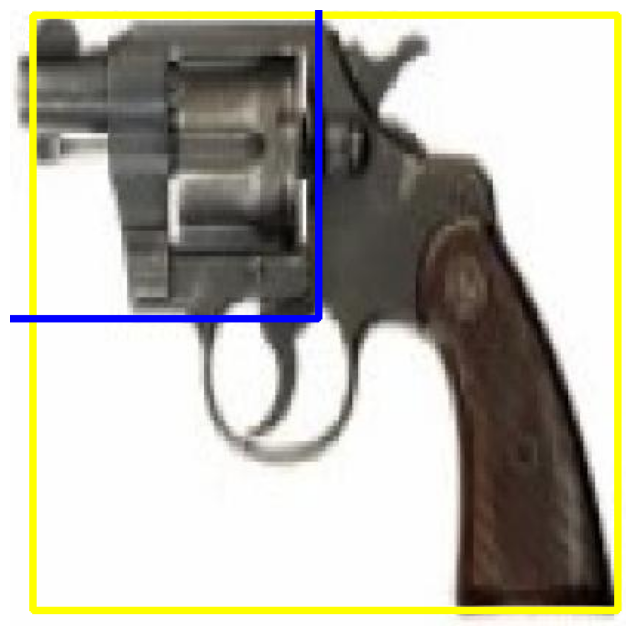

In [28]:
index = 101

label = y_test_box[index]

img = x_test[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ", label)
print("Predicted Bbox: ", pred_box)

plot_prediction(img, label, pred_box)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Ground Truth:  [0. 0. 0. 0.]
Predicted Bbox:  [0. 0. 0. 0.]
ImgResolution (416, 416, 3)


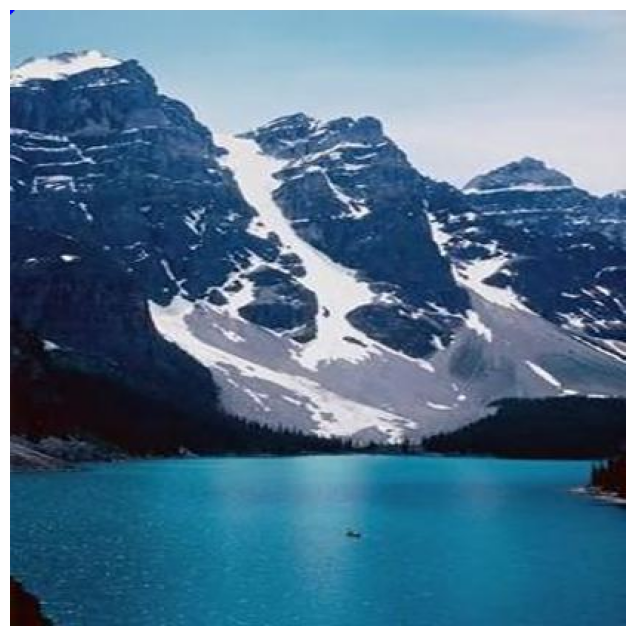

In [29]:
index = 5

label = y_test_box[index]

img = x_test[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ", label)
print("Predicted Bbox: ", pred_box)

plot_prediction(img, label, pred_box)

# Is There A Better Way To Evaluate Bounding Box Prediction? (Introducing IoU As The Evaluation Metric Of BBox)
IoU, also known as Jaccard Index, is a widely used metric in object detection to measure the overlap between the predicted bounding box and the ground truth bounding box.

### How IoU works?
1. Calculate intersection: Determine the area of overlap between the predicted and ground truth bounding boxes.
2. Calculate union: Determine the total area covered by both the predicted and ground truth bounding boxes combined.
3. Calculate IoU: Divide the area of intersection by the area of union.

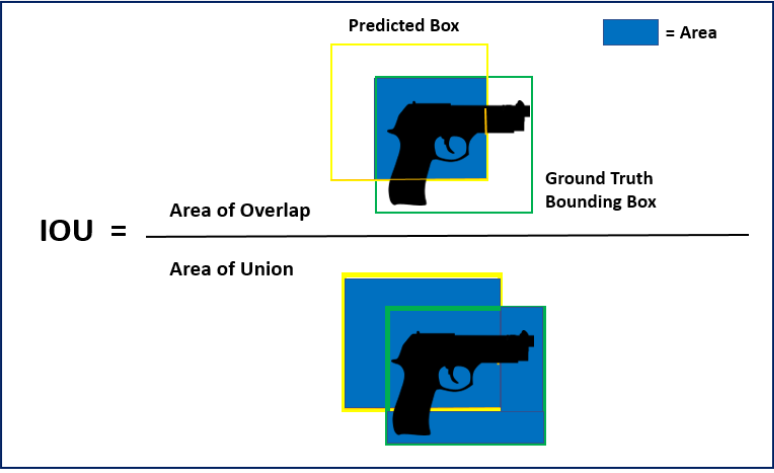

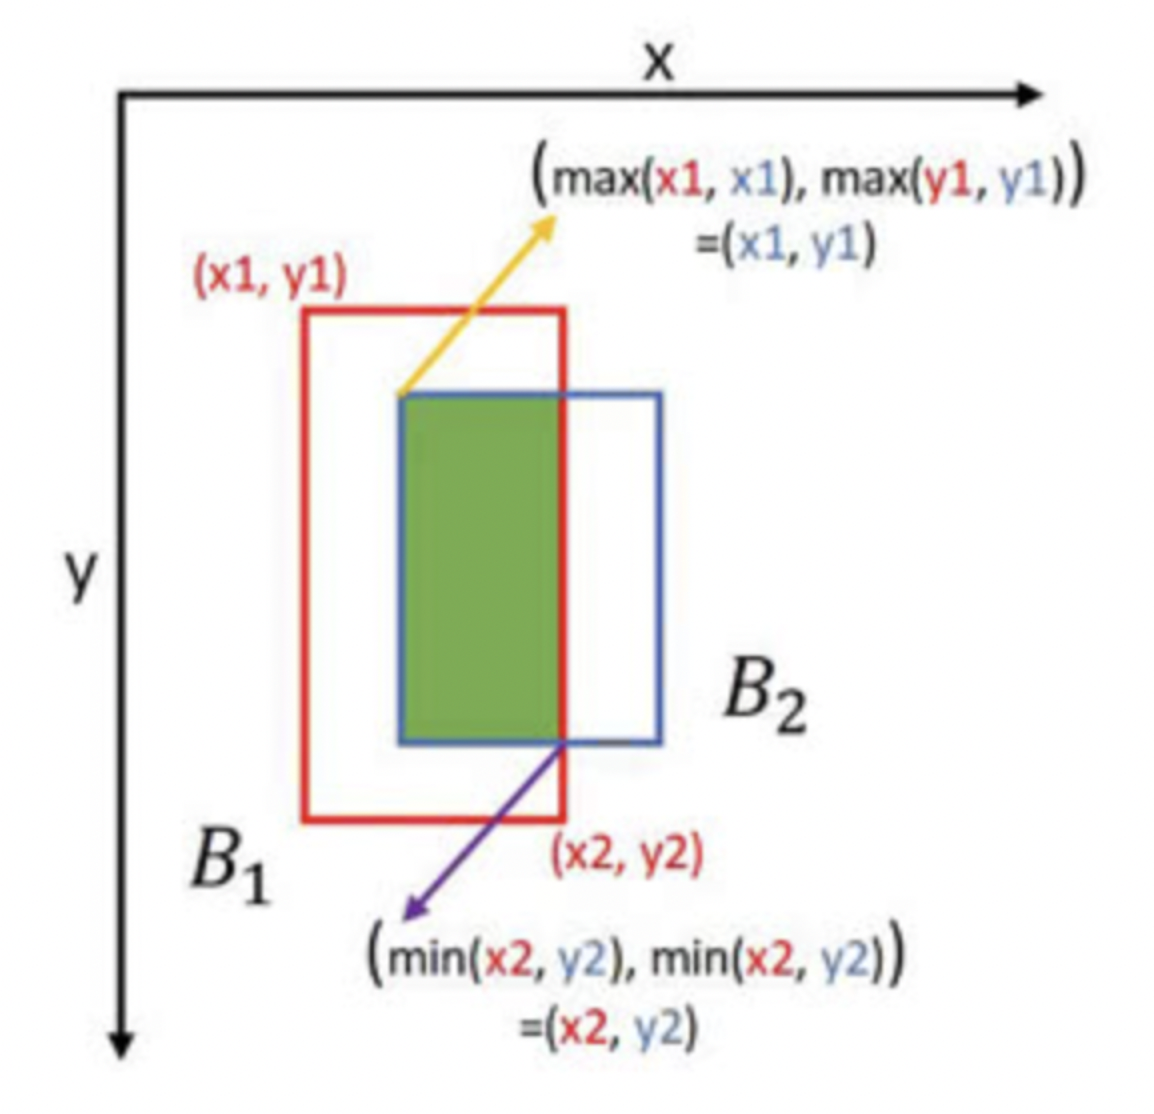

### Interpretation of IoU score
- IoU = 0: No overlap between the boxes.
- IoU = 1: Prefect overlap, the predicted box perfectly matches the ground truth box.
- 0 < IoU < 1: Partial overlap, with higher values indicating better alignment.

### Why IoU is better?
- Scale-invariant: Unlike metrics that rely on absolute distances, IoU is scale-invariant. This means it is not affected by the size of the object being detected.
- Focuses on overlap: IoU directly measures the degree of overlap between the predicted and ground truth boxes, which is more relevant for object detection tasks than simply measuring the distance between box centers.
- Widely used: IoU is a standard metric in object detection research and evaluation, making it easy to compare results with other models and benchmarks.

### Advanced IoU metrics
- Generalized IoU (GIoU): Addresses the limitations of IoU when there's no overlap by considering the minimum area enclosing both boxes.
- Distance-IoU (DIoU): Incorporates the center point distance and aspect ratio difference between the boxes.
- Complete IoU (CIoU): Further refines DIoU by considering the normalized distance between the centers of the boxes and their aspect ratio.

These advanced IoU metrics provide more nuanced evaluation of bounding box predictions, leading to better model training and improved object detection performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Ground Truth:  [0.21939954 0.43021583 0.26096998 0.23741007]
Predicted Bbox:  [0.0000000e+00 1.2928192e-36 0.0000000e+00 0.0000000e+00]
ImgResolution (416, 416, 3)


0.16342899654103446

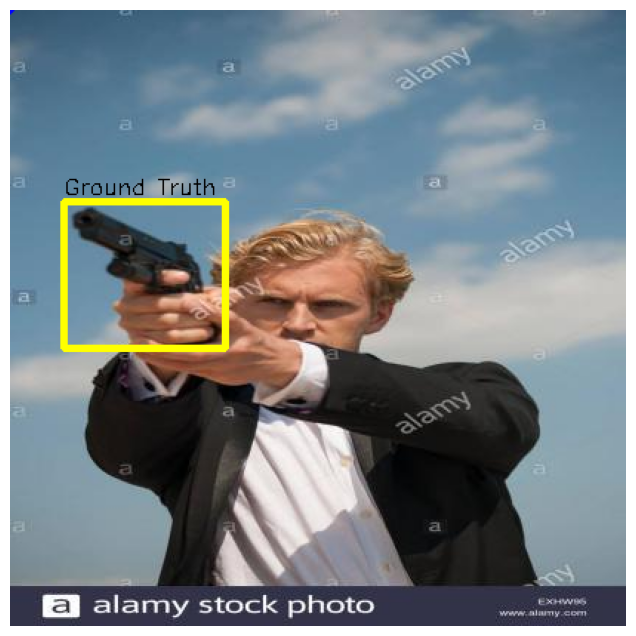

In [30]:
def compute_iou(label_box, pred_box):
    # determine the (x, y)-coordinates of the intersection rectangle
    gt = [0,0,0,0]
    x1, y1, x2, y2 = cv_coords(label_box)
    gt[0], gt[1], gt[2], gt[3] = x1, y1, x2, y2

    pred = [0,0,0,0]
    x1, y1, x2, y2=cv_coords(pred_box)
    pred[0], pred[1], pred[2], pred[3] = x1, y1, x2, y2

    inter_box_top_left = [max(gt[0], pred[0]), max(gt[1], pred[1])]
    inter_box_bottom_right = [min(gt[0] + gt[2], pred[0] + pred[2]), min(gt[1] + gt[3], pred[1] + pred[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt[2] * gt[3] + pred[2] * pred[3] - intersection

    iou_area = intersection / (union + 10e-3)
    return iou_area

index = 100

label = y_train_box[index]

img = x_train[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ",label )
print("Predicted Bbox: ", pred_box)

plot_prediction(img, label, pred_box)
compute_iou(label, pred_box)

### Mean IoU
Mean IoU can be calculated by simply calculating IoU for all images in the test set and then taking an average.

In [31]:
def mean_intersection_over_union(X_test,gt_box, pred_box):
    iou = []
    for ind in range(len(X_test)):
        iou_area = compute_iou(gt_box[ind], pred_box[ind])
        iou.append(iou_area)
    iou = np.array(iou)
    return np.mean(iou)

gt_box = y_train_box
pred_box = predict(x_train, ResNet101_final, "batch")[0]

train_meanIOU = mean_intersection_over_union(x_train, gt_box, pred_box)

print(f"Mean IoU Train: {train_meanIOU}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step
Mean IoU Train: 0.0787628302478942


In [32]:
gt_box = y_test_box
pred_box = predict(x_test, ResNet101_final, 'batch')[0]

test_meanIOU = mean_intersection_over_union(x_test, gt_box, pred_box)

print(f"Mean IoU Test: {test_meanIOU}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step
Mean IoU Test: 0.14233085982404892


### Observations about Object Localization
- The output of Object Localization is fixed (i.e., 4 output coordinates that means only 1 bounding box).
- Only a single object present in an image can be localized using Object Localization.

# Detecting Multiple Objects In An Image - Object Detection
To find multiple objects in an image, Object Detection algorithms are used.

### Key differences
- Object Localization:
    - Focuses on finding a single object within an image.
    - Outputs a single bounding box and its class probability.
- Object Detection:
    - Aims to identify and locate multiple objects of different classes within an image.
    - Outputs multiple bounding boxes, each with its corresponding class probability.

### How Object Detection works?
1. Region proposal:
    - Traditional methods: Techniques like Selective Search or Edge Boxes generate potential regions of interest (ROIs) within the image.
    - Modern approaches: Region Proposal Networks (RPNs) with Deep Learning models like R-CNN efficiently generate proposals.
2. Feature extraction: Convolutional Neural Networks (CNNs) extract features from the entire image or the proposed regions.
2. Classification and Bounding Box Regression:
    - A Classifier predicts the class of each object within the proposed regions.
    - A Regressor refines the Bounding Box coordinates to better fit the actual object.

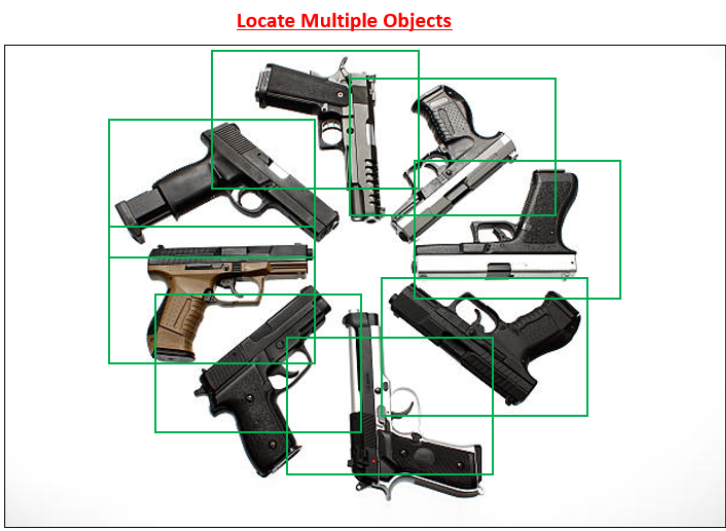

# Sliding Window Detection
"Slide a box across an image and classify each image crop inside a box".

Sliding Window detection is a fundamental technique in object detection, where a small window of a fixed size in moved systamatically across an image. At each position, a classifier (e.g., a Machine Learning model) analyzes the content within the window to determine if it contains an object of interest.

### How does Sliding Window work?
1. Define a window: A rectangular window of a specific size is created.
2. Slide across image: This window is symmetrically moved across the entire image, often with a certain stride (e.g., moving the window by a few pixels at each step).
3. Classification at each position: At each position, the image within the window is extracted and fed into a classifier (e.g., a pre-trained CNN).
4. Object detection: If the classifier predicts that the window contains the object of interest (e.g., a car), the window's position and size are considered a potential object detection.

### Why can Sliding Windows be considered as classification?
- Binary classification: At its core, the sliding window approach can be seen as a series of binary classification problems. For each window, the Classifier decides:
    - "Is there an object of interest within this window? (Yes/ No)".

### Limitation of Sliding Windows
- Computational cost: Processing every window with a Classifier can be computationally expensive, especially for large images or dense sliding windows.
- Fixed window size: Objects can vary in size, and a single fixed window size may not effectively detect objects of different scales.
- Inefficient: Many windows will contain no objects, leading to unnessary computations.

### Improvements and modern approaches
- Region Proposal Methods: Techniques like Selective Search and Region Proposal Networks (RPNs) generate more intelligent proposals for potential object locations, reducing the computational burden.
- Convolutional Neural Networks (CNNs): Modern object detection models like faster R-CNN, YOLO, and SSD leverage the power of CNNs to directly learn features and predict bounding boxes, making them significantly more efficient and accurate than traditional Sliding Window approaches.